In [2]:
import torch
import torchvision
print(f"torch version: {torch.__version__}")
print(f"torchvision version: {torchvision.__version__}")
import matplotlib.pyplot as plt


torch version: 1.13.1+cu116
torchvision version: 0.14.1+cu116


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
from pathlib import Path
train_data = Path('/content/drive/MyDrive/train')
test_data = Path('/content/drive/MyDrive/test')
val_data = Path('/content/drive/MyDrive/valid')

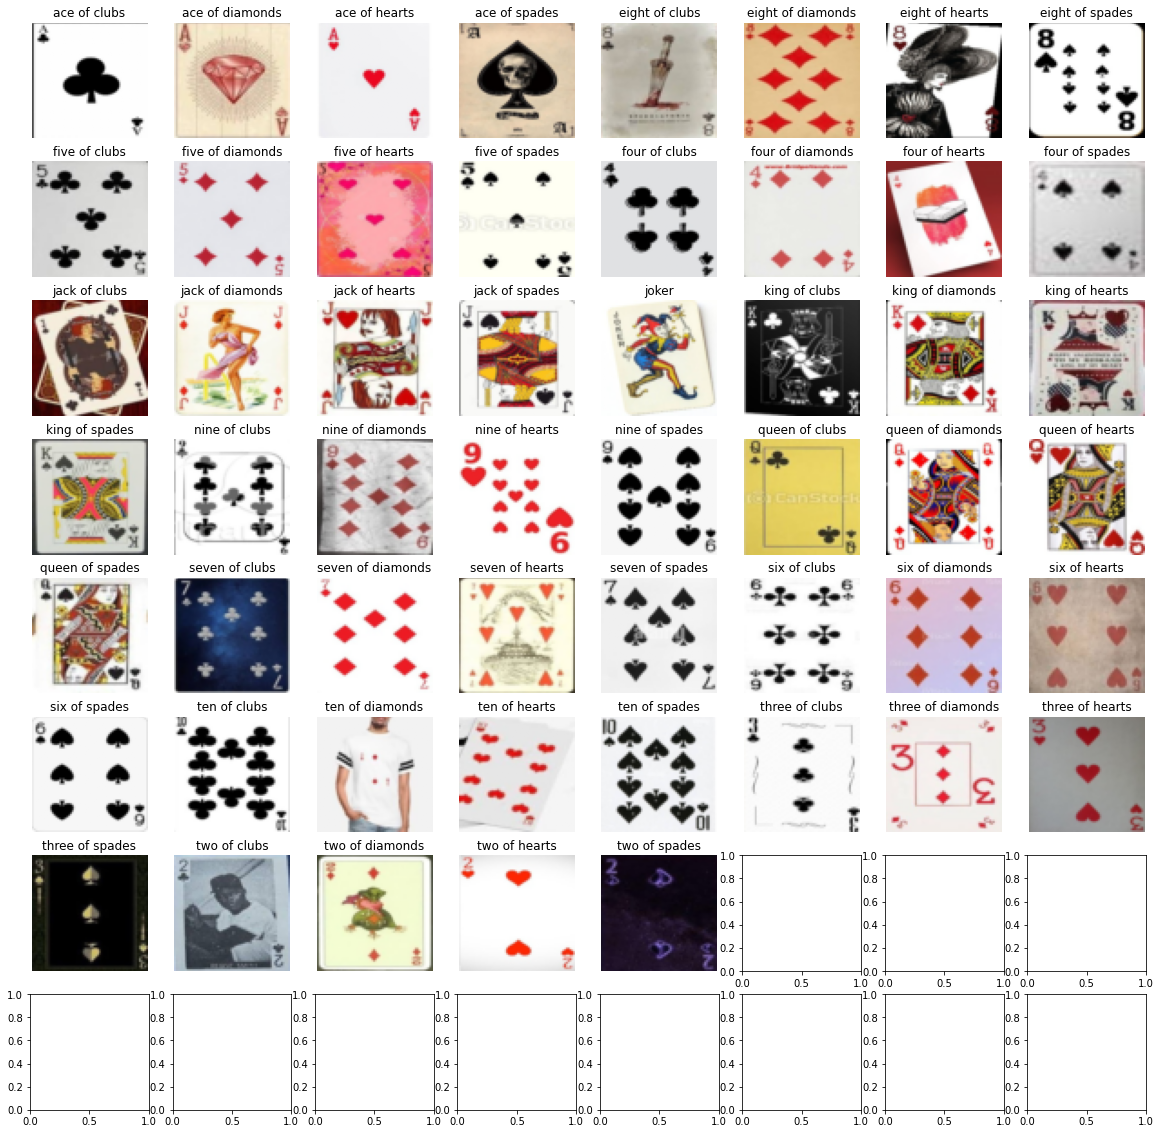

In [9]:
from PIL import Image
import os
import torchvision.transforms as transforms
train_data = Path('/content/drive/MyDrive/train')

# Define the number of images per row and column
images_per_row = 8
images_per_col = 8

# Define the image pre-processing
transform = transforms.Compose([transforms.Resize((64, 64)), transforms.ToTensor()])

fig, axs = plt.subplots(8, 8, figsize=(20, 20))
axs = axs.ravel()

for i, subfolder in enumerate(os.listdir(train_data)):
    subfolder_path = os.path.join(train_data, subfolder)
    for j, file in enumerate(os.listdir(subfolder_path)):
        file_path = os.path.join(subfolder_path, file)
        subfolder_image = Image.open(file_path)
        subfolder_image = transform(subfolder_image)
        axs[i].imshow(subfolder_image.permute(1, 2, 0))
        axs[i].set_title(subfolder)
        axs[i].axis('off')
plt.show()



In [10]:
from torchvision import datasets
train_data = datasets.ImageFolder(root= train_data, # target folder of images
                                  transform=transform, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

test_data = datasets.ImageFolder(root=test_data, 
                                 transform=transform)

val_data = datasets.ImageFolder(root=val_data, 
                                 transform=transform)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}\nVal data:\n{val_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 7624
    Root location: /content/drive/MyDrive/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 265
    Root location: /content/drive/MyDrive/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )
Val data:
Dataset ImageFolder
    Number of datapoints: 265
    Root location: /content/drive/MyDrive/valid
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )


In [11]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=32, shuffle=True)

train_dataloader,test_dataloader,val_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7fae27f157c0>,
 <torch.utils.data.dataloader.DataLoader at 0x7fae24a92880>)

In [12]:
from torch import nn 

class TinyVGG(nn.Module):
    """Creates the TinyVGG architecture.

    Replicates the TinyVGG architecture from the CNN explainer website in PyTorch.
    See the original architecture here: https://poloclub.github.io/cnn-explainer/

    Args:
    input_shape: An integer indicating number of input channels.
    hidden_units: An integer indicating number of hidden units between layers.
    output_shape: An integer indicating number of output units.
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
          nn.Conv2d(in_channels=input_shape, 
                    out_channels=hidden_units, 
                    kernel_size=3, 
                    stride=1, 
                    padding=0),  
          nn.ReLU(),
          nn.Conv2d(in_channels=hidden_units, 
                    out_channels=hidden_units,
                    kernel_size=3,
                    stride=1,
                    padding=0),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2,
                        stride=2)
        )
        self.conv_block_2 = nn.Sequential(
          nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=0),
          nn.ReLU(),
          nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=0),
          nn.ReLU(),
          nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
          nn.Flatten(),
          # Where did this in_features shape come from? 
          # It's because each layer of our network compresses and changes the shape of our inputs data.
          nn.Linear(in_features=hidden_units*13*13,
                    out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        #print(x.shape)
        x = self.conv_block_2(x)
        #print(x.shape)
        x = self.classifier(x)
        #print(x.shape)
        return x

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Instantiate an instance of the model
torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB) 
                  hidden_units=10, 
                  output_shape=len(train_data.classes)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=53, bias=True)
  )
)

In [14]:
img_batch, label_batch = next(iter(train_dataloader))

# 2. Get a single image from the batch and unsqueeze the image so its shape fits the model
img_single, label_single = img_batch[1].unsqueeze(dim=0), label_batch[1]
print(f"Single image shape: {img_single.shape}\n")

# 3. Perform a forward pass on a single image
model_0.eval()
with torch.inference_mode():
    pred = model_0(img_single.to(device))
    
# 4. Print out what's happening and convert model logits -> pred probs -> pred label
print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:\n{label_single}")

Single image shape: torch.Size([1, 3, 64, 64])

Output logits:
tensor([[ 0.0051,  0.0187,  0.0229,  0.0210,  0.0054, -0.0020,  0.0232,  0.0704,
          0.0067, -0.0859, -0.0213,  0.0708,  0.0035,  0.0030,  0.0295,  0.0064,
         -0.0180,  0.0020,  0.0613, -0.0056,  0.0757, -0.0293,  0.0457, -0.0315,
         -0.0308, -0.0099, -0.0438,  0.0058,  0.0029, -0.0225, -0.0087, -0.0415,
          0.0591, -0.0240,  0.0407,  0.0253,  0.0694,  0.0503,  0.0253,  0.0103,
         -0.0241,  0.0073, -0.0456,  0.0403, -0.0688, -0.0108, -0.0719,  0.0655,
          0.0712,  0.0089, -0.0690, -0.0196, -0.0038]], device='cuda:0')

Output prediction probabilities:
tensor([[0.0189, 0.0191, 0.0192, 0.0192, 0.0189, 0.0187, 0.0192, 0.0201, 0.0189,
         0.0172, 0.0184, 0.0201, 0.0188, 0.0188, 0.0193, 0.0189, 0.0184, 0.0188,
         0.0199, 0.0187, 0.0202, 0.0182, 0.0196, 0.0182, 0.0182, 0.0186, 0.0180,
         0.0189, 0.0188, 0.0183, 0.0186, 0.0180, 0.0199, 0.0183, 0.0195, 0.0192,
         0.0201, 0.0

In [15]:
from typing import Tuple

def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
    """Trains a PyTorch model for a single epoch.

    Turns a target PyTorch model to training mode and then
    runs through all of the required training steps (forward
    pass, loss calculation, optimizer step).

    Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:

    (0.1112, 0.8743)
    """
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [16]:
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
    """Tests a PyTorch model for a single epoch.

    Turns a target PyTorch model to "eval" mode and then performs
    a forward pass on a testing dataset.

    Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:

    (0.0223, 0.8985)
    """
    # Put model in eval mode
    model.eval() 

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [17]:
from typing import Dict, List

from tqdm.auto import tqdm

def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List[float]]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for 
    each epoch.
    In the form: {train_loss: [...],
                  train_acc: [...],
                  test_loss: [...],
                  test_acc: [...]} 
    For example if training for epochs=2: 
                 {train_loss: [2.0616, 1.0537],
                  train_acc: [0.3945, 0.3945],
                  test_loss: [1.2641, 1.5706],
                  test_acc: [0.3400, 0.2973]} 
    """
    # Create empty results dictionary
    results = {"train_loss": [],
      "train_acc": [],
      "test_loss": [],
      "test_acc": []
    }

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # Return the filled results at the end of the epochs
    return results

In [19]:
# Set number of epochs
NUM_EPOCHS = 15

# Recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB) 
                  hidden_units=10, 
                  output_shape=len(train_data.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Train model_0 
model_0_results = train(model=model_0, 
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS,
                        device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.5363 | train_acc: 0.1093 | test_loss: 2.5364 | test_acc: 0.3075
Epoch: 2 | train_loss: 2.2768 | train_acc: 0.4055 | test_loss: 1.8162 | test_acc: 0.5567
Epoch: 3 | train_loss: 1.8248 | train_acc: 0.5161 | test_loss: 1.7186 | test_acc: 0.5930
Epoch: 4 | train_loss: 1.5053 | train_acc: 0.6012 | test_loss: 1.5251 | test_acc: 0.6346
Epoch: 5 | train_loss: 1.2156 | train_acc: 0.6748 | test_loss: 1.6129 | test_acc: 0.6713
Epoch: 6 | train_loss: 0.9856 | train_acc: 0.7325 | test_loss: 1.5506 | test_acc: 0.6644
Epoch: 7 | train_loss: 0.7738 | train_acc: 0.7873 | test_loss: 1.5377 | test_acc: 0.6941
Epoch: 8 | train_loss: 0.5932 | train_acc: 0.8368 | test_loss: 1.7469 | test_acc: 0.6867
Epoch: 9 | train_loss: 0.4452 | train_acc: 0.8747 | test_loss: 2.0849 | test_acc: 0.6817
Epoch: 10 | train_loss: 0.3570 | train_acc: 0.9009 | test_loss: 2.2636 | test_acc: 0.6481
Epoch: 11 | train_loss: 0.2702 | train_acc: 0.9246 | test_loss: 2.3315 | test_acc: 0.7114
Epoch: 12 | train_l

In [21]:
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
img_size = 224
trans = transforms.Compose([
    transforms.Pad(8, padding_mode='reflect'),
    transforms.RandomCrop(img_size),
    transforms.ToTensor(),
    transforms.Normalize(*imagenet_stats)
])

In [23]:
train_data = datasets.ImageFolder(root= '/content/drive/MyDrive/train', # target folder of images
                                  transform=trans, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

test_data = datasets.ImageFolder(root='/content/drive/MyDrive/test', 
                                 transform=trans)

val_data = datasets.ImageFolder(root='/content/drive/MyDrive/valid', 
                                 transform=trans)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}\nVal data:\n{val_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 7624
    Root location: /content/drive/MyDrive/train
    StandardTransform
Transform: Compose(
               Pad(padding=8, fill=0, padding_mode=reflect)
               RandomCrop(size=(224, 224), padding=None)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 265
    Root location: /content/drive/MyDrive/test
    StandardTransform
Transform: Compose(
               Pad(padding=8, fill=0, padding_mode=reflect)
               RandomCrop(size=(224, 224), padding=None)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Val data:
Dataset ImageFolder
    Number of datapoints: 265
    Root location: /content/drive/MyDrive/valid
    StandardTransform
Transform: Compose(
               Pad(padding=8, fill=0, padding_mode=reflect)
               

In [24]:
from torch.utils.data import DataLoader
batch_size = 256

train_dl = DataLoader(train_data, batch_size, shuffle=True, num_workers=4, pin_memory=True)
valid_dl = DataLoader(val_data, batch_size*2, num_workers=4, pin_memory=True)
test_dl =  DataLoader(test_data, batch_size*2, num_workers=4, pin_memory=True)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [25]:
import torch.nn as nn
import torch.nn.functional as F

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels)  # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}],{} train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, "last_lr: {:.5f},".format(result['lrs'][-1]) if 'lrs' in result else '', 
            result['train_loss'], result['val_loss'], result['val_acc']))

In [26]:
from torchvision import models

class CardIdentifier(ImageClassificationBase):
    def __init__(self, num_classes, pretrained=True):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet34(pretrained=pretrained)
        # Replace last layer
        self.network.fc = nn.Linear(self.network.fc.in_features, num_classes)

    def forward(self, xb):
        return self.network(xb)

In [27]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')


def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [28]:
import torch
from tqdm.notebook import tqdm

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [29]:
device = get_default_device()
device

device(type='cuda')

In [30]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

In [31]:
model = CardIdentifier(len(train_data.classes))
to_device(model, device);

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [32]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 4.192962169647217, 'val_acc': 0.01886792480945587}]

In [33]:
epochs = 6
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [34]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [0],last_lr: 0.00591, train_loss: 1.7020, val_loss: 103.4123, val_acc: 0.0189


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [1],last_lr: 0.00994, train_loss: 1.1465, val_loss: 3.6605, val_acc: 0.4226


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [2],last_lr: 0.00812, train_loss: 0.5951, val_loss: 0.3984, val_acc: 0.8906


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [3],last_lr: 0.00463, train_loss: 0.3648, val_loss: 0.1349, val_acc: 0.9623


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [4],last_lr: 0.00133, train_loss: 0.2191, val_loss: 0.0719, val_acc: 0.9811


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [5],last_lr: 0.00000, train_loss: 0.1304, val_loss: 0.0557, val_acc: 0.9849
CPU times: user 1min 24s, sys: 1min 27s, total: 2min 52s
Wall time: 3min 58s
